# Análisis de Convergencia Temporal para PCB

## Objetivo
Este notebook determina el tiempo necesario para que el solver transitorio de la PCB alcance un régimen cuasi-estacionario, permitiendo optimizar los parámetros de simulación para la generación de datasets.

## Metodología
1. **Generación de casos aleatorios** con diferentes condiciones de contorno
2. **Comparación** entre solución estacionaria y transitoria
3. **Detección de convergencia** usando error máximo absoluto
4. **Análisis estadístico** para determinar percentiles de convergencia

# Importaciones y configuración del entorno


In [1]:
import numpy as np
import pandas as pd
import os
import sys
import time
import torch

# =============== CONFIGURACIÓN DE RUTAS ===============
base_path = os.path.dirname(__file__) if '__file__' in globals() else os.getcwd()

# Añadir 'scripts'
script_path = os.path.join(base_path, '..', 'scripts')
sys.path.append(os.path.abspath(script_path))

# path directorie for saving datasets
path = os.path.join(base_path, 'datasets')
if not os.path.exists(path):
    os.makedirs(path)

# =============== CONFIGURACIÓN DE DIRECTORIO PARA FIGURAS ===============
figures_base_path = os.path.join(base_path, 'figures')
figures_path = os.path.join(figures_base_path, 'convergence_study')

# Crear directorios si no existen
if not os.path.exists(figures_base_path):
    os.makedirs(figures_base_path)
    print(f"📁 Directorio creado: {figures_base_path}")

if not os.path.exists(figures_path):
    os.makedirs(figures_path)
    print(f"📁 Directorio creado: {figures_path}")

# =============== IMPORTACIONES ESPECÍFICAS ===============
from PCB_solver_tr import PCB_case_2
# from Dataset_Class_convlstm import PCBDataset_convlstm

print("✅ Configuración completada")
print(f"📁 Directorio base: {base_path}")
# print(f"📁 Scripts path: {script_path}")
# print(f"📁 Datasets path: {path}")
print(f"📁 Figures path: {figures_path}")

✅ Configuración completada
📁 Directorio base: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo
📁 Figures path: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\figures\convergence_study


In [2]:
# # =============== CONFIGURACIÓN DE MATPLOTLIB ===============
# import matplotlib.pyplot as plt

# # Configuración global para fondo blanco
# plt.rcParams['figure.facecolor'] = 'white'
# plt.rcParams['axes.facecolor'] = 'white'
# plt.rcParams['savefig.facecolor'] = 'white'
# plt.rcParams['savefig.edgecolor'] = 'white'

# # Configuraciones adicionales para mejor visualización
# plt.rcParams['figure.edgecolor'] = 'white'
# plt.rcParams['axes.edgecolor'] = 'black'
# plt.rcParams['axes.linewidth'] = 0.8

# # Para asegurar compatibilidad con temas oscuros de VS Code
# plt.rcParams['text.color'] = 'black'
# plt.rcParams['axes.labelcolor'] = 'black'
# plt.rcParams['xtick.color'] = 'black'
# plt.rcParams['ytick.color'] = 'black'

# print("✅ Configuración de matplotlib para fondo blanco aplicada")

In [3]:
# =============== CONFIGURACIÓN DE MATPLOTLIB ===============
import matplotlib.pyplot as plt

plt.style.use('default')
plt.rcParams["figure.figsize"] = (6,4)
#plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.family"] = "lmroman10-regular"
plt.rcParams["font.size"] = 14
plt.rcParams["text.usetex"] = True
plt.rcParams["axes.titlesize"] = 14

# Parámetros de configuración

In [4]:
# =============== PARÁMETROS DE SIMULACIÓN ===============
n_data = 10000          # Número de casos a analizar
time_sim = 1000         # Tiempo máximo de simulación [s]
dt = 1                  # Paso temporal [s]
T_init = 298.0          # Temperatura inicial [K]

# =============== PARÁMETROS DE CONVERGENCIA ===============
epsilon = 1             # Umbral de error máximo absoluto [K]
pasos_estables = 10     # Pasos consecutivos bajo el umbral para considerar convergencia

print(f"🔧 Configuración del análisis:")
print(f"   📊 Casos a analizar: {n_data}")
print(f"   ⏱️  Tiempo máximo: {time_sim}s")
print(f"   📏 Umbral convergencia: {epsilon}K")
print(f"   🎯 Pasos estables requeridos: {pasos_estables}")

🔧 Configuración del análisis:
   📊 Casos a analizar: 10000
   ⏱️  Tiempo máximo: 1000s
   📏 Umbral convergencia: 1K
   🎯 Pasos estables requeridos: 10


# Funciones auxiliares

## Funciones auxiliares - Generación de casos

In [5]:
# Celda 4: Funciones auxiliares - Generación de casos
# =============== GENERACIÓN DE CASOS ÚNICOS ===============
np.random.seed(0)  # Para reproducibilidad

def generate_unique_cases(n_data):
    """
    Genera casos únicos evitando duplicados para asegurar diversidad en el análisis.
    
    Args:
        n_data: Número de casos únicos a generar
        
    Returns:
        Q_list: Array de potencias de heaters [W] - shape (n_data, 4)
        T_int_list: Array de temperaturas de interfaces [K] - shape (n_data, 4)  
        T_env_list: Array de temperaturas ambiente [K] - shape (n_data,)
    """
    seen = set()
    Q_list, T_int_list, T_env_list = [], [], []
    
    while len(Q_list) < n_data:
        # Generar condiciones aleatorias
        Q = tuple(np.random.uniform(0.5, 1.5, 4).round(6))        # Potencias [0.5-1.5W]
        T_int = tuple(np.random.uniform(270, 320, 4).round(2))    # Interfaces [270-320K]
        T_env = round(float(np.random.uniform(270, 320)), 2)      # Ambiente [270-320K]
        
        # Crear clave única para evitar duplicados
        key = Q + T_int + (T_env,)
        
        if key not in seen:
            seen.add(key)
            Q_list.append(Q)
            T_int_list.append(T_int)
            T_env_list.append(T_env)
    
    return np.array(Q_list), np.array(T_int_list), np.array(T_env_list)

print("✅ Función de generación de casos definida")

✅ Función de generación de casos definida


## Funciones de análisis - Detección de convergencia

In [6]:
# =============== DETECCIÓN DE RÉGIMEN ESTACIONARIO ===============

def detectar_estacionario(T_transient, T_steady, epsilon=5.0, pasos_estables=5, dt=1.0):
    """
    Detecta cuándo el solver transitorio alcanza el régimen cuasi-estacionario.
    
    Metodología:
    - Calcula error máximo absoluto en cada paso temporal
    - Busca secuencia de pasos consecutivos bajo el umbral
    - Retorna el primer paso donde se alcanza la convergencia
    
    Args:
        T_transient: Evolución temporal transitoria - shape (n_steps, H, W)
        T_steady: Solución estacionaria de referencia - shape (H, W)
        epsilon: Umbral de error máximo absoluto [K]
        pasos_estables: Número de pasos consecutivos bajo umbral
        dt: Paso temporal [s]
        
    Returns:
        paso_estacionario: Paso donde se detecta convergencia (None si no converge)
        tiempo_estacionario: Tiempo de convergencia [s] (None si no converge)
        errores: Array con evolución del error máximo
    """
    errores = []
    
    # =============== CÁLCULO DEL ERROR TEMPORAL ===============
    for frame in T_transient:
        error_max = np.max(np.abs(frame - T_steady))  # Error MÁXIMO absoluto [K]
        errores.append(error_max)

    errores = np.array(errores)
    
    # =============== BÚSQUEDA DE CONVERGENCIA ===============
    contador = 0
    for i, err in enumerate(errores):
        if err < epsilon:
            contador += 1
            if contador >= pasos_estables:
                # ¡Convergencia detectada!
                paso_estacionario = i - pasos_estables + 1
                tiempo_estacionario = paso_estacionario * dt
                return paso_estacionario, tiempo_estacionario, errores
        else:
            contador = 0  # Reset si error supera umbral

    # No convergió en el tiempo simulado
    return None, None, errores

print("✅ Función de detección de convergencia definida")

✅ Función de detección de convergencia definida


## Función principal de análisis

In [7]:
# =============== ANÁLISIS MASIVO DE CASOS ===============

def analizar_n_casos(n_data=10, time_sim=1000.0, dt=1.0, T_init=298.0, epsilon=5, pasos_estables=5):
    """
    Ejecuta análisis de convergencia para múltiples casos aleatorios.
    
    Proceso por caso:
    1. Genera condiciones de contorno aleatorias
    2. Ejecuta solver estacionario (referencia)
    3. Ejecuta solver transitorio (evolución temporal)
    4. Detecta punto de convergencia
    5. Registra resultados
    
    Args:
        n_data: Número de casos a analizar
        time_sim: Tiempo máximo de simulación [s]
        dt: Paso temporal [s]
        T_init: Temperatura inicial [K]
        epsilon: Umbral de convergencia [K]
        pasos_estables: Pasos consecutivos requeridos
        
    Returns:
        DataFrame con resultados del análisis
    """
    print(f"🚀 Iniciando análisis de {n_data} casos...")
    
    # =============== GENERACIÓN DE CASOS ===============
    Q_random, T_interfaces_random, T_env_random = generate_unique_cases(n_data)
    resultados = []

    # =============== ANÁLISIS CASO POR CASO ===============
    for i in range(n_data):
        if i % 100 == 0:  # Progress indicator
            print(f"   📊 Procesando caso {i}/{n_data}...")
            
        # Condiciones para este caso
        Q = Q_random[i]
        T_int = T_interfaces_random[i]
        T_env = T_env_random[i]

        # =============== SOLVER ESTACIONARIO (REFERENCIA) ===============
        T_steady, _, _, _ = PCB_case_2(
            solver='steady', display=False, time=time_sim, dt=dt,
            T_init=T_init, Q_heaters=Q, T_interfaces=T_int, Tenv=T_env
        )

        # =============== SOLVER TRANSITORIO (EVOLUCIÓN) ===============
        T_transient, _, _, _ = PCB_case_2(
            solver='transient', display=False, time=time_sim, dt=dt,
            T_init=T_init, Q_heaters=Q, T_interfaces=T_int, Tenv=T_env
        )

        # =============== DETECCIÓN DE CONVERGENCIA ===============
        paso, tiempo, errores = detectar_estacionario(
            T_transient, T_steady,
            epsilon=epsilon,
            pasos_estables=pasos_estables,
            dt=dt
        )
        
        # =============== REGISTRO DE RESULTADOS ===============
        resultados.append({
            'Caso': i,
            'Paso_estacionario': paso,
            'Tiempo_estacionario': tiempo,
            'Error_final': errores[-1] if len(errores) > 0 else None,
            'Q': Q,
            'T_int': T_int,
            'T_env': T_env
        })

        # Status para casos individuales
        status = "✅ OK" if paso is not None else "❌ NO CONVERGIÓ"
        if i < 10 or i % 50 == 0:  # Mostrar detalles para primeros casos
            print(f'   Caso {i:3d}: {status} en paso {paso}, tiempo {tiempo}s')

    print(f"🎉 Análisis completado!")
    return pd.DataFrame(resultados)

print("✅ Función de análisis masivo definida")

✅ Función de análisis masivo definida


## Funciones de análisis estadístico

In [8]:
# =============== ANÁLISIS ESTADÍSTICO AVANZADO ===============

def calcular_tiempo_para_percentil(df_resultados, percentil=99):
    """
    Calcula el tiempo necesario para que un porcentaje específico de casos converja.
    
    Propósito: Determinar time_sim óptimo para asegurar convergencia en el X% de casos.
    
    Args:
        df_resultados: DataFrame con resultados del análisis
        percentil: Porcentaje de casos que deben converger (ej: 99 para 99%)
    
    Returns:
        tiempo_requerido: Tiempo necesario para que el percentil% converja
        estadisticas: Dict con estadísticas detalladas
    """
    # =============== FILTRADO DE DATOS ===============
    casos_convergidos = df_resultados[df_resultados['Paso_estacionario'].notna()]
    casos_no_convergidos = df_resultados[df_resultados['Paso_estacionario'].isna()]
    
    total_casos = len(df_resultados)
    n_convergidos = len(casos_convergidos)
    n_no_convergidos = len(casos_no_convergidos)
    
    # =============== REPORTE DE CONVERGENCIA ===============
    print(f"\n📊 Análisis de convergencia:")
    print(f"   Total casos: {total_casos}")
    print(f"   Convergidos: {n_convergidos} ({n_convergidos/total_casos*100:.1f}%)")
    print(f"   No convergidos: {n_no_convergidos} ({n_no_convergidos/total_casos*100:.1f}%)")
    
    if n_convergidos == 0:
        print("❌ Ningún caso convergió. Intenta con:")
        print("   - epsilon más alto (menos estricto)")
        print("   - time_sim más largo")
        print("   - pasos_estables menor")
        return None, None
    
    # =============== CÁLCULO DE PERCENTILES ===============
    tiempos_convergencia = casos_convergidos['Tiempo_estacionario'].values
    tiempo_requerido = np.percentile(tiempos_convergencia, percentil)
    
    # =============== ESTADÍSTICAS COMPLETAS ===============
    estadisticas = {
        'total_casos': total_casos,
        'casos_convergidos': n_convergidos,
        'casos_no_convergidos': n_no_convergidos,
        'porcentaje_convergido': n_convergidos/total_casos*100,
        'tiempo_min': tiempos_convergencia.min(),
        'tiempo_max': tiempos_convergencia.max(),
        'tiempo_promedio': tiempos_convergencia.mean(),
        'tiempo_mediana': np.median(tiempos_convergencia),
        f'tiempo_p{percentil}': tiempo_requerido
    }
    
    # =============== REPORTE ESTADÍSTICO ===============
    print(f"\n⏱️  Estadísticas de tiempo de convergencia:")
    print(f"   Mínimo: {estadisticas['tiempo_min']:.0f}s")
    print(f"   Promedio: {estadisticas['tiempo_promedio']:.0f}s")
    print(f"   Mediana: {estadisticas['tiempo_mediana']:.0f}s")
    print(f"   Máximo: {estadisticas['tiempo_max']:.0f}s")
    print(f"   Percentil {percentil}: {tiempo_requerido:.0f}s")
    
    print(f"\n🎯 Para que el {percentil}% de los casos converja:")
    print(f"   Tiempo necesario: {tiempo_requerido:.0f}s")
    
    return tiempo_requerido, estadisticas

def recomendar_time_sim(df_resultados, percentil_objetivo=99, margen_seguridad=1.2):
    """
    Recomienda un time_sim óptimo para generación de datasets.
    
    Args:
        df_resultados: DataFrame con resultados
        percentil_objetivo: Porcentaje de casos que deben converger
        margen_seguridad: Factor de seguridad (1.2 = 20% extra)
    """
    tiempo_requerido, stats = calcular_tiempo_para_percentil(df_resultados, percentil_objetivo)
    
    if tiempo_requerido is None:
        return None
    
    time_sim_recomendado = tiempo_requerido * margen_seguridad
    
    print(f"\n💡 Recomendación para generación de datasets:")
    print(f"   Para {percentil_objetivo}% de convergencia: {tiempo_requerido:.0f}s")
    print(f"   Con margen de seguridad ({margen_seguridad}x): {time_sim_recomendado:.0f}s")
    print(f"   time_sim recomendado: {int(time_sim_recomendado)}")
    
    return int(time_sim_recomendado)

print("✅ Funciones de análisis estadístico definidas")

✅ Funciones de análisis estadístico definidas


## Función de visualización

In [9]:
def visualizar_convergencia(df_resultados, percentil=99, save_fig=True):
    """
    Genera visualizaciones comprehensivas de la distribución de convergencia.
    
    Genera:
    1. Histograma de tiempos de convergencia
    2. Función de distribución acumulada (CDF)
    """
    casos_convergidos = df_resultados[df_resultados['Paso_estacionario'].notna()]
    
    if len(casos_convergidos) == 0:
        print("❌ No hay casos convergidos para visualizar")
        return
    
    tiempos = casos_convergidos['Tiempo_estacionario'].values
    tiempo_percentil = np.percentile(tiempos, percentil)
    
    # =============== CONFIGURACIÓN DE BINS PARA 10s DE ANCHO ===============
    tiempo_min = tiempos.min()
    tiempo_max = tiempos.max()
    # Calcular bins para que cada bin tenga 10s de ancho
    bins = np.arange(tiempo_min - tiempo_min % 10, tiempo_max + 10, 10)
    
    # =============== CONFIGURACIÓN DE FIGURA ===============
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle(f'Convergence Analysis - {len(casos_convergidos)} cases', 
                 fontsize=14, fontweight='bold')
    
    # =============== SUBPLOT 1: HISTOGRAMA ===============
    ax1.hist(tiempos, bins=bins, alpha=0.7, edgecolor='black', color='skyblue')
    ax1.axvline(tiempo_percentil, color='red', linestyle='--', linewidth=2,
                label=f'{percentil}th percentile: {tiempo_percentil:.0f}s')
    ax1.axvline(tiempos.mean(), color='green', linestyle=':', linewidth=2,
                label=f'Mean: {tiempos.mean():.0f}s')
    
    # Configuración con solo líneas horizontales
    ax1.set_xlim(tiempos.min() * 0.95, tiempos.max() * 1.05)
    ax1.set_xlabel('Convergence time [s]')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Distribution of convergence times')
    ax1.legend()
    ax1.grid(True, alpha=0.7, linestyle='-', linewidth=0.5, color='gray', axis='y')  # Solo líneas horizontales
    ax1.minorticks_on()
    
    # =============== SUBPLOT 2: CDF ===============
    tiempos_sorted = np.sort(tiempos)
    percentiles = np.arange(1, len(tiempos_sorted) + 1) / len(tiempos_sorted) * 100
    
    ax2.plot(tiempos_sorted, percentiles, 'b-', linewidth=2, label='CDF')
    ax2.axhline(percentil, color='red', linestyle='--', alpha=0.7)
    ax2.axvline(tiempo_percentil, color='red', linestyle='--', alpha=0.7,
                label=f'{percentil}% at {tiempo_percentil:.0f}s')
    
    # Configuración con cuadrícula mejorada y límites del eje Y
    ax2.set_xlim(tiempos_sorted[0] * 0.95, tiempos_sorted[-1] * 1.05)
    ax2.set_ylim(0, 100)  # Límites del eje Y: 0% a 100%
    ax2.set_xlabel('Convergence time [s]')
    ax2.set_ylabel('Cumulative percentile [\%]')
    ax2.set_title('Cumulative distribution function')
    ax2.legend()
    ax2.grid(True, alpha=0.7, linestyle='-', linewidth=0.5, color='gray')
    ax2.grid(True, alpha=0.3, linestyle=':', linewidth=0.3, color='gray', which='minor')
    ax2.minorticks_on()
    
    plt.tight_layout()
    
    # =============== GUARDAR FIGURAS POR SEPARADO SIN TÍTULO ===============
    if save_fig:
        # Guardar histograma por separado
        fig1, ax1_save = plt.subplots(figsize=(8, 6), facecolor='white')
        fig1.patch.set_facecolor('white')
        ax1_save.set_facecolor('white')
        
        ax1_save.hist(tiempos, bins=bins, alpha=0.7, edgecolor='black', color='skyblue')
        ax1_save.axvline(tiempo_percentil, color='red', linestyle='--', linewidth=2,
                        label=f'{percentil}th percentile: {tiempo_percentil:.0f}s')
        ax1_save.axvline(tiempos.mean(), color='green', linestyle=':', linewidth=2,
                        label=f'Mean: {tiempos.mean():.0f}s')
        
        ax1_save.set_xlim(tiempos.min() * 0.95, tiempos.max() * 1.05)
        ax1_save.set_xlabel('Convergence time [s]')
        ax1_save.set_ylabel('Frequency')
        ax1_save.legend()
        ax1_save.grid(True, alpha=0.7, linestyle='-', linewidth=0.5, color='gray', axis='y')  # Solo líneas horizontales
        ax1_save.minorticks_on()
        ax1_save.tick_params(colors='black')
        
        filename1 = f"convergence_histogram_p{percentil}.pdf"
        filepath1 = os.path.join(figures_path, filename1)
        fig1.savefig(filepath1, dpi=300, bbox_inches='tight', facecolor='white')
        plt.close(fig1)
        print(f"💾 Figura guardada: {filepath1}")
        
        # Guardar CDF por separado
        fig2, ax2_save = plt.subplots(figsize=(8, 6), facecolor='white')
        fig2.patch.set_facecolor('white')
        ax2_save.set_facecolor('white')
        
        ax2_save.plot(tiempos_sorted, percentiles, 'b-', linewidth=2, label='CDF')
        ax2_save.axhline(percentil, color='red', linestyle='--', alpha=0.7)
        ax2_save.axvline(tiempo_percentil, color='red', linestyle='--', alpha=0.7,
                        label=f'{percentil}% at {tiempo_percentil:.0f}s')
        
        ax2_save.set_xlim(tiempos_sorted[0] * 0.95, tiempos_sorted[-1] * 1.05)
        ax2_save.set_ylim(0, 100)
        ax2_save.set_xlabel('Convergence time [s]')
        ax2_save.set_ylabel('Cumulative percentile [\%]')
        ax2_save.legend()
        ax2_save.grid(True, alpha=0.7, linestyle='-', linewidth=0.5, color='gray')
        ax2_save.grid(True, alpha=0.3, linestyle=':', linewidth=0.3, color='gray', which='minor')
        ax2_save.minorticks_on()
        ax2_save.tick_params(colors='black')
        
        filename2 = f"convergence_cdf_p{percentil}.pdf"
        filepath2 = os.path.join(figures_path, filename2)
        fig2.savefig(filepath2, dpi=300, bbox_inches='tight', facecolor='white')
        plt.close(fig2)
        print(f"💾 Figura guardada: {filepath2}")
    
    plt.show()
    
    # =============== ESTADÍSTICAS EN TEXTO ===============
    print(f"\n📈 Estadísticas de la visualización:")
    print(f"   Casos mostrados: {len(casos_convergidos)}")
    print(f"   Tiempo mínimo: {tiempos.min():.0f}s")
    print(f"   Tiempo máximo: {tiempos.max():.0f}s")
    print(f"   Desviación estándar: {tiempos.std():.0f}s")

## Análisis detallado de evolución temporal

In [10]:
# =============== ANÁLISIS DETALLADO DE EVOLUCIÓN TEMPORAL ===============

def analizar_evolucion_detallada(n_casos_detalle=1, nodos_seleccionados=[(1, 1)]):
    """
    Analiza la evolución temporal detallada de nodos específicos para casos seleccionados.
    
    Args:
        n_casos_detalle: Número de casos a analizar en detalle
        nodos_seleccionados: Lista de coordenadas (i, j) de nodos a monitorear
        
    Returns:
        dict con datos de evolución temporal por caso
    """
    print(f"🔍 Analizando evolución detallada de {n_casos_detalle} casos...")
    
    # Generar casos para análisis detallado
    Q_random, T_interfaces_random, T_env_random = generate_unique_cases(n_casos_detalle)
    
    evoluciones = {}
    
    for caso in range(n_casos_detalle):
        print(f"   📊 Procesando caso {caso+1}/{n_casos_detalle} para análisis detallado...")
        
        Q = Q_random[caso]
        T_int = T_interfaces_random[caso]
        T_env = T_env_random[caso]
        
        # =============== SOLVER ESTACIONARIO ===============
        T_steady_1d, _, _, _ = PCB_case_2(
            solver='steady', display=False, time=time_sim, dt=dt,
            T_init=T_init, Q_heaters=Q, T_interfaces=T_int, Tenv=T_env
        )
        
        # =============== SOLVER TRANSITORIO ===============
        T_transient_1d, _, _, _ = PCB_case_2(
            solver='transient', display=False, time=time_sim, dt=dt,
            T_init=T_init, Q_heaters=Q, T_interfaces=T_int, Tenv=T_env
        )
        
        # =============== CONVERSIÓN A FORMATO 2D (13x13) ===============
        print(f"   🔧 Formato original: T_steady shape = {T_steady_1d.shape}")
        print(f"   🔧 Formato original: T_transient shape = {T_transient_1d.shape}")
        
        # Convertir estacionario de (169,) a (13, 13)
        T_steady = T_steady_1d.reshape(13, 13)
        
        # Convertir transitorio de (n_steps, 169) a (n_steps, 13, 13)
        T_transient = T_transient_1d.reshape(T_transient_1d.shape[0], 13, 13)
        
        print(f"   ✅ Formato convertido: T_steady shape = {T_steady.shape}")
        print(f"   ✅ Formato convertido: T_transient shape = {T_transient.shape}")
        
        # =============== DETECCIÓN DE CONVERGENCIA ===============
        paso_conv, tiempo_conv, errores = detectar_estacionario(
            T_transient, T_steady, epsilon=epsilon, pasos_estables=pasos_estables, dt=dt
        )
        
        # =============== EXTRACCIÓN DE DATOS DE NODOS ===============
        tiempo_steps = np.arange(0, len(T_transient)) * dt
        
        evolucion_nodos = {}
        for idx, (i, j) in enumerate(nodos_seleccionados):
            # Verificar que las coordenadas están dentro de los límites (13x13)
            if 0 <= i < 13 and 0 <= j < 13:
                evolucion_nodos[f'Nodo_{idx+1}_{i}_{j}'] = {
                    'transitorio': [frame[i, j] for frame in T_transient],
                    'estacionario': T_steady[i, j],
                    'coordenadas': (i, j)
                }
                print(f"   📍 Nodo ({i},{j}): T_steady = {T_steady[i, j]:.2f}K")
            else:
                print(f"   ⚠️  Coordenadas ({i},{j}) fuera de rango [0-12, 0-12]")
        
        evoluciones[f'Caso_{caso+1}'] = {
            'tiempo': tiempo_steps,
            'nodos': evolucion_nodos,
            'convergencia': {
                'paso': paso_conv,
                'tiempo': tiempo_conv,
                'errores': errores
            },
            'condiciones': {
                'Q': Q,
                'T_int': T_int,
                'T_env': T_env
            }
        }
    
    return evoluciones

def visualizar_evolucion_temporal(evoluciones, caso_a_mostrar='Caso_1', save_fig=True):
    """
    Visualiza la evolución temporal de nodos específicos con bandas de convergencia.
    
    Args:
        evoluciones: Dict con datos de evolución temporal
        caso_a_mostrar: Qué caso mostrar en la visualización
    """
    if caso_a_mostrar not in evoluciones:
        print(f"❌ Caso {caso_a_mostrar} no encontrado")
        return
    
    datos_caso = evoluciones[caso_a_mostrar]
    tiempo = datos_caso['tiempo']
    nodos = datos_caso['nodos']
    convergencia = datos_caso['convergencia']
    
    # =============== CONFIGURACIÓN DE FIGURA CON FONDO BLANCO ===============
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), facecolor='white')
    fig.patch.set_facecolor('white')
    fig.suptitle(f'Temporal Evolution - {caso_a_mostrar}', 
                 fontsize=16, fontweight='bold', color='black')
    
    # =============== SUBPLOT 1: EVOLUCIÓN DE TEMPERATURA ===============
    ax1.set_facecolor('white')
    colores = ['blue', 'red', 'green', 'orange', 'purple', 'brown']
    
    for idx, (nombre_nodo, datos_nodo) in enumerate(nodos.items()):
        color = colores[idx % len(colores)]
        coords = datos_nodo['coordenadas']  # (i, j)
        
        # Línea de evolución transitoria
        ax1.plot(tiempo, datos_nodo['transitorio'], 
                label=f'Node ({coords[0]},{coords[1]})', color=color, linewidth=2)
        
        # Línea de referencia estacionaria
        T_steady_nodo = datos_nodo['estacionario']
        ax1.axhline(T_steady_nodo, color=color, linestyle='--', alpha=0.7, linewidth=1)
        
        # Banda de convergencia (±epsilon) con formato mejorado
        ax1.fill_between(tiempo, 
                        T_steady_nodo - epsilon, 
                        T_steady_nodo + epsilon,
                        color=color, alpha=0.1, 
                        label=f'Band ±{epsilon}K')
    
    # Línea vertical de convergencia
    if convergencia['tiempo'] is not None:
        ax1.axvline(convergencia['tiempo'], color='black', linestyle=':', linewidth=2,
                   label=f'Convergence: {convergencia["tiempo"]:.0f}s')
    
    # =============== CONFIGURACIÓN DEL EJE X LIMITADO Y CUADRÍCULA ===============
    ax1.set_xlim(tiempo[0], tiempo[-1])
    ax1.set_xlabel('Time [s]', color='black')
    ax1.set_ylabel('Temperature [K]', color='black')
    ax1.set_title('Temperature Evolution at Selected Nodes', color='black')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Cuadrícula más visible
    ax1.grid(True, alpha=0.7, linestyle='-', linewidth=0.5, color='gray')
    ax1.grid(True, alpha=0.3, linestyle=':', linewidth=0.3, color='gray', which='minor')
    ax1.minorticks_on()
    ax1.tick_params(colors='black')
    
    # =============== SUBPLOT 2: ERROR MÁXIMO GLOBAL ===============
    ax2.set_facecolor('white')
    tiempo_error = tiempo[:len(convergencia['errores'])]
    ax2.plot(tiempo_error, convergencia['errores'], 'k-', linewidth=2, label='Maximum error')
    ax2.axhline(epsilon, color='red', linestyle='--', linewidth=2, 
               label=f'Threshold: {epsilon}K')
    
    if convergencia['tiempo'] is not None:
        ax2.axvline(convergencia['tiempo'], color='black', linestyle=':', linewidth=2,
                   label=f'Convergence: {convergencia["tiempo"]:.0f}s')
    
    # =============== CONFIGURACIÓN DEL EJE X Y Y LIMITADOS ===============
    ax2.set_xlim(tiempo_error[0], tiempo_error[-1])
    ax2.set_ylim(0, None)
    ax2.set_xlabel('Time [s]', color='black')
    ax2.set_ylabel('Maximum absolute error [K]', color='black')
    ax2.set_title('Evolution of Global Maximum Error', color='black')
    ax2.legend()
    
    # Cuadrícula más visible y escala lineal (NO logarítmica)
    ax2.grid(True, alpha=0.7, linestyle='-', linewidth=0.5, color='gray')
    ax2.grid(True, alpha=0.3, linestyle=':', linewidth=0.3, color='gray', which='minor')
    ax2.minorticks_on()
    ax2.tick_params(colors='black')
    
    plt.tight_layout()
    
    # =============== GUARDAR FIGURAS POR SEPARADO SIN TÍTULO ===============
    if save_fig:
        # Guardar subplot 1 (evolución temporal) por separado
        fig1, ax1_save = plt.subplots(figsize=(10, 6), facecolor='white')
        fig1.patch.set_facecolor('white')
        ax1_save.set_facecolor('white')
        
        for idx, (nombre_nodo, datos_nodo) in enumerate(nodos.items()):
            color = colores[idx % len(colores)]
            coords = datos_nodo['coordenadas']  # (i, j)
            
            ax1_save.plot(tiempo, datos_nodo['transitorio'], 
                         label=f'Node ({coords[0]},{coords[1]})', color=color, linewidth=2)
            T_steady_nodo = datos_nodo['estacionario']
            ax1_save.axhline(T_steady_nodo, color=color, linestyle='--', alpha=0.7, linewidth=1)
            ax1_save.fill_between(tiempo, T_steady_nodo - epsilon, T_steady_nodo + epsilon,
                                 color=color, alpha=0.1, 
                                 label=f'Band ±{epsilon}K')
        
        if convergencia['tiempo'] is not None:
            ax1_save.axvline(convergencia['tiempo'], color='black', linestyle=':', linewidth=2,
                           label=f'Convergence: {convergencia["tiempo"]:.0f}s')
        
        ax1_save.set_xlim(tiempo[0], tiempo[-1])
        ax1_save.set_xlabel('Time [s]', color='black')
        ax1_save.set_ylabel('Temperature [K]', color='black')
        ax1_save.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax1_save.grid(True, alpha=0.7, linestyle='-', linewidth=0.5, color='gray')
        ax1_save.grid(True, alpha=0.3, linestyle=':', linewidth=0.3, color='gray', which='minor')
        ax1_save.minorticks_on()
        ax1_save.tick_params(colors='black')
        
        filename1 = f"temperature_evolution_{caso_a_mostrar.lower()}.pdf"
        filepath1 = os.path.join(figures_path, filename1)
        fig1.savefig(filepath1, dpi=300, bbox_inches='tight', facecolor='white')
        plt.close(fig1)
        print(f"💾 Figura guardada: {filepath1}")
        
        # Guardar subplot 2 (error) por separado
        fig2, ax2_save = plt.subplots(figsize=(10, 6), facecolor='white')
        fig2.patch.set_facecolor('white')
        ax2_save.set_facecolor('white')
        
        ax2_save.plot(tiempo_error, convergencia['errores'], 'k-', linewidth=2, label='Maximum error')
        ax2_save.axhline(epsilon, color='red', linestyle='--', linewidth=2, 
                        label=f'Threshold: {epsilon}K')
        
        if convergencia['tiempo'] is not None:
            ax2_save.axvline(convergencia['tiempo'], color='black', linestyle=':', linewidth=2,
                           label=f'Convergence: {convergencia["tiempo"]:.0f}s')
        
        ax2_save.set_xlim(tiempo_error[0], tiempo_error[-1])
        ax2_save.set_ylim(0, None)
        ax2_save.set_xlabel('Time [s]', color='black')
        ax2_save.set_ylabel('Maximum Absolute Error [K]', color='black')
        ax2_save.legend()
        ax2_save.grid(True, alpha=0.7, linestyle='-', linewidth=0.5, color='gray')
        ax2_save.grid(True, alpha=0.3, linestyle=':', linewidth=0.3, color='gray', which='minor')
        ax2_save.minorticks_on()
        ax2_save.tick_params(colors='black')
        
        filename2 = f"error_evolution_{caso_a_mostrar.lower()}.pdf"
        filepath2 = os.path.join(figures_path, filename2)
        fig2.savefig(filepath2, dpi=300, bbox_inches='tight', facecolor='white')
        plt.close(fig2)
        print(f"💾 Figura guardada: {filepath2}")
    
    plt.show()
    
    # =============== REPORTE TEXTUAL ===============
    print(f"\n📊 Resumen para {caso_a_mostrar}:")
    condiciones = datos_caso['condiciones']
    print(f"   🔥 Potencias: {condiciones['Q']}")
    print(f"   🌡️  T_env: {condiciones['T_env']}K")
    
    if convergencia['tiempo'] is not None:
        print(f"   ✅ Convergencia alcanzada en {convergencia['tiempo']:.0f}s")
        print(f"   📈 Error final: {convergencia['errores'][-1]:.3f}K")
    else:
        print(f"   ❌ No convergió en {time_sim}s")
        print(f"   📈 Error final: {convergencia['errores'][-1]:.3f}K")
    
    print(f"\n🎯 Temperaturas finales vs estacionarias:")
    for nombre_nodo, datos_nodo in nodos.items():
        T_final = datos_nodo['transitorio'][-1]
        T_steady = datos_nodo['estacionario']
        error_nodo = abs(T_final - T_steady)
        coords = datos_nodo['coordenadas']
        print(f"   {nombre_nodo} ({coords}): {T_final:.2f}K vs {T_steady:.2f}K (Δ={error_nodo:.3f}K)")
        
def comparar_casos_evolucion(evoluciones, save_fig=True):
    """
    Compara la evolución de un nodo específico entre diferentes casos.
    """
    if not evoluciones:
        print("❌ No hay datos de evolución para comparar")
        return
    
    # Seleccionar el primer nodo para comparación
    primer_caso = list(evoluciones.values())[0]
    primer_nodo_key = list(primer_caso['nodos'].keys())[0]
    primer_nodo_coords = primer_caso['nodos'][primer_nodo_key]['coordenadas']
    
    # =============== CONFIGURACIÓN DE FIGURA CON FONDO BLANCO ===============
    fig, ax = plt.subplots(figsize=(12, 8), facecolor='white')
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    ax.set_title(f'Temporal Evolution Comparison - Node ({primer_nodo_coords[0]},{primer_nodo_coords[1]})', color='black')
    
    colores = ['blue', 'red', 'green', 'orange', 'purple']
    
    # Variables para determinar límites del eje X
    tiempo_min = float('inf')
    tiempo_max = float('-inf')
    
    for idx, (nombre_caso, datos_caso) in enumerate(evoluciones.items()):
        if primer_nodo_key in datos_caso['nodos']:
            color = colores[idx % len(colores)]
            tiempo = datos_caso['tiempo']
            temp_transitoria = datos_caso['nodos'][primer_nodo_key]['transitorio']
            temp_estacionaria = datos_caso['nodos'][primer_nodo_key]['estacionario']
            
            # Actualizar límites del tiempo
            tiempo_min = min(tiempo_min, tiempo[0])
            tiempo_max = max(tiempo_max, tiempo[-1])
            
            # Convertir nombre del caso de "Caso_X" a "Case X"
            caso_numero = nombre_caso.split('_')[1]  # Extraer el número
            caso_en_ingles = f'Case {caso_numero}'
            
            # Evolución transitoria
            ax.plot(tiempo, temp_transitoria, color=color, linewidth=2,
                   label=f'{caso_en_ingles}')
            
            # Referencia estacionaria
            ax.axhline(temp_estacionaria, color=color, linestyle='--', alpha=0.7)
            
            # Banda de convergencia
            ax.fill_between(tiempo, 
                           temp_estacionaria - epsilon,
                           temp_estacionaria + epsilon,
                           color=color, alpha=0.1)
            
            # Línea de convergencia
            if datos_caso['convergencia']['tiempo'] is not None:
                ax.axvline(datos_caso['convergencia']['tiempo'], 
                          color=color, linestyle=':', alpha=0.8)
    
    # =============== CONFIGURACIÓN DE EJES Y CUADRÍCULA ===============
    ax.set_xlim(tiempo_min, tiempo_max)
    ax.set_xlabel('Time [s]', color='black')
    ax.set_ylabel('Temperature [K]', color='black')
    ax.legend()
    
    # Cuadrícula más visible
    ax.grid(True, alpha=0.7, linestyle='-', linewidth=0.5, color='gray')
    ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.3, color='gray', which='minor')
    ax.minorticks_on()
    ax.tick_params(colors='black')
    
    plt.tight_layout()
    
    # =============== GUARDAR FIGURA SIN TÍTULO ===============
    if save_fig:
        fig_save, ax_save = plt.subplots(figsize=(12, 8), facecolor='white')
        fig_save.patch.set_facecolor('white')
        ax_save.set_facecolor('white')
        
        for idx, (nombre_caso, datos_caso) in enumerate(evoluciones.items()):
            if primer_nodo_key in datos_caso['nodos']:
                color = colores[idx % len(colores)]
                tiempo = datos_caso['tiempo']
                temp_transitoria = datos_caso['nodos'][primer_nodo_key]['transitorio']
                temp_estacionaria = datos_caso['nodos'][primer_nodo_key]['estacionario']
                
                # Convertir nombre del caso de "Caso_X" a "Case X"
                caso_numero = nombre_caso.split('_')[1]  # Extraer el número
                caso_en_ingles = f'Case {caso_numero}'
                
                ax_save.plot(tiempo, temp_transitoria, color=color, linewidth=2,
                           label=f'{caso_en_ingles}')
                ax_save.axhline(temp_estacionaria, color=color, linestyle='--', alpha=0.7)
                ax_save.fill_between(tiempo, temp_estacionaria - epsilon, temp_estacionaria + epsilon,
                                   color=color, alpha=0.1)
                
                if datos_caso['convergencia']['tiempo'] is not None:
                    ax_save.axvline(datos_caso['convergencia']['tiempo'], 
                                  color=color, linestyle=':', alpha=0.8)
        
        ax_save.set_xlim(tiempo_min, tiempo_max)
        ax_save.set_xlabel('Time [s]', color='black')
        ax_save.set_ylabel('Temperature [K]', color='black')
        ax_save.legend()
        ax_save.grid(True, alpha=0.7, linestyle='-', linewidth=0.5, color='gray')
        ax_save.grid(True, alpha=0.3, linestyle=':', linewidth=0.3, color='gray', which='minor')
        ax_save.minorticks_on()
        ax_save.tick_params(colors='black')
        
        filename = "temporal_evolution_comparison.pdf"
        filepath = os.path.join(figures_path, filename)
        fig_save.savefig(filepath, dpi=300, bbox_inches='tight', facecolor='white')
        plt.close(fig_save)
        print(f"💾 Figura guardada: {filepath}")
    
    plt.show()

# Ejecución del análisis principal

In [11]:
# =============== EJECUCIÓN DEL ANÁLISIS ===============
print("🔄 Ejecutando análisis de convergencia...")
start_time = time.time()

df_resultados = analizar_n_casos(
    n_data=n_data, 
    time_sim=time_sim, 
    dt=dt, 
    epsilon=epsilon, 
    pasos_estables=10
)

elapsed_time = time.time() - start_time
print(f"⏱️ Análisis completado en {elapsed_time:.1f}s")

# =============== RESUMEN RÁPIDO ===============
total_casos = len(df_resultados)
casos_convergidos = df_resultados['Paso_estacionario'].notna().sum()
casos_no_convergidos = total_casos - casos_convergidos

print(f"\n📋 Resumen preliminar:")
print(f"   Total casos: {total_casos}")
print(f"   Convergidos: {casos_convergidos} ({casos_convergidos/total_casos*100:.1f}%)")
print(f"   No convergidos: {casos_no_convergidos} ({casos_no_convergidos/total_casos*100:.1f}%)")

if casos_convergidos > 0:
    tiempos = df_resultados['Tiempo_estacionario'].dropna()
    print(f"   Tiempo promedio: {tiempos.mean():.0f}s")
    print(f"   Tiempo mediana: {tiempos.median():.0f}s")
    print(f"   Rango: {tiempos.min():.0f}s - {tiempos.max():.0f}s")

🔄 Ejecutando análisis de convergencia...
🚀 Iniciando análisis de 10000 casos...
   📊 Procesando caso 0/10000...
   Caso   0: ✅ OK en paso 508, tiempo 508s
   Caso   1: ✅ OK en paso 498, tiempo 498s
   Caso   2: ✅ OK en paso 473, tiempo 473s
   Caso   3: ✅ OK en paso 489, tiempo 489s
   Caso   4: ✅ OK en paso 498, tiempo 498s
   Caso   5: ✅ OK en paso 372, tiempo 372s
   Caso   6: ✅ OK en paso 462, tiempo 462s
   Caso   7: ✅ OK en paso 461, tiempo 461s
   Caso   8: ✅ OK en paso 435, tiempo 435s
   Caso   9: ✅ OK en paso 501, tiempo 501s
   Caso  50: ✅ OK en paso 492, tiempo 492s
   📊 Procesando caso 100/10000...
   Caso 100: ✅ OK en paso 400, tiempo 400s
   Caso 150: ✅ OK en paso 488, tiempo 488s
   📊 Procesando caso 200/10000...
   Caso 200: ✅ OK en paso 466, tiempo 466s
   Caso 250: ✅ OK en paso 501, tiempo 501s
   📊 Procesando caso 300/10000...
   Caso 300: ✅ OK en paso 493, tiempo 493s
   Caso 350: ✅ OK en paso 485, tiempo 485s
   📊 Procesando caso 400/10000...
   Caso 400: ✅ OK en 

# Ejecución del análisis final

In [12]:
# =============== ANÁLISIS FINAL Y RECOMENDACIONES ===============
print("🔍 Ejecutando análisis estadístico completo...")

# =============== ANÁLISIS DE PERCENTILES ===============
tiempo_99, stats = calcular_tiempo_para_percentil(df_resultados, percentil=99)

🔍 Ejecutando análisis estadístico completo...

📊 Análisis de convergencia:
   Total casos: 10000
   Convergidos: 10000 (100.0%)
   No convergidos: 0 (0.0%)

⏱️  Estadísticas de tiempo de convergencia:
   Mínimo: 132s
   Promedio: 461s
   Mediana: 479s
   Máximo: 510s
   Percentil 99: 508s

🎯 Para que el 99% de los casos converja:
   Tiempo necesario: 508s



📊 Generando visualizaciones...
💾 Figura guardada: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\figures\convergence_study\convergence_histogram_p99.pdf
💾 Figura guardada: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\figures\convergence_study\convergence_cdf_p99.pdf


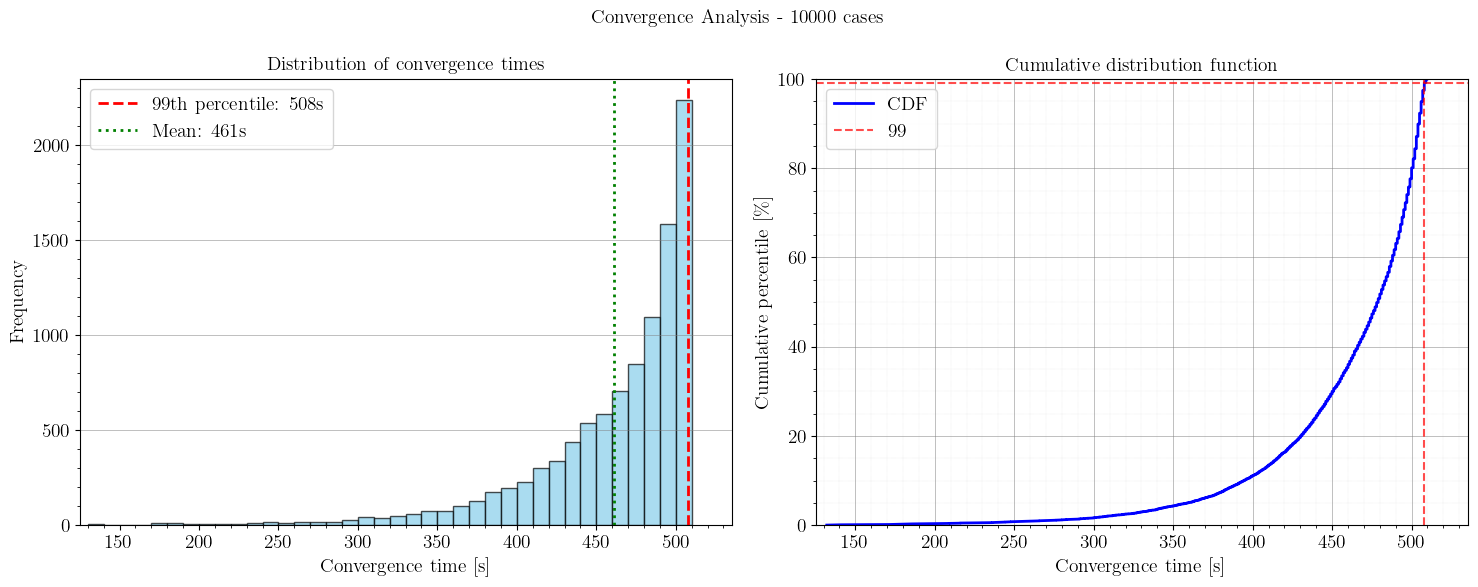


📈 Estadísticas de la visualización:
   Casos mostrados: 10000
   Tiempo mínimo: 132s
   Tiempo máximo: 510s
   Desviación estándar: 51s


In [13]:
# =============== VISUALIZACIÓN ===============
print("\n📊 Generando visualizaciones...")
visualizar_convergencia(df_resultados, percentil=99)

In [14]:
# =============== RECOMENDACIÓN FINAL ===============
print("\n🎯 Calculando recomendación final...")
time_sim_optimo = recomendar_time_sim(df_resultados, percentil_objetivo=99, margen_seguridad=1.2)


🎯 Calculando recomendación final...

📊 Análisis de convergencia:
   Total casos: 10000
   Convergidos: 10000 (100.0%)
   No convergidos: 0 (0.0%)

⏱️  Estadísticas de tiempo de convergencia:
   Mínimo: 132s
   Promedio: 461s
   Mediana: 479s
   Máximo: 510s
   Percentil 99: 508s

🎯 Para que el 99% de los casos converja:
   Tiempo necesario: 508s

💡 Recomendación para generación de datasets:
   Para 99% de convergencia: 508s
   Con margen de seguridad (1.2x): 610s
   time_sim recomendado: 609


In [15]:
# =============== RESUMEN EJECUTIVO ===============
print("\n" + "="*60)
print("📋 RESUMEN EJECUTIVO")
print("="*60)

if time_sim_optimo is not None:
    print(f"✅ time_sim recomendado: {time_sim_optimo}s")
    print(f"✅ Esto garantiza convergencia del 99% de casos")
    print(f"✅ Incluye 20% de margen de seguridad")
    
    # Comparación con configuración actual
    if time_sim_optimo > time_sim:
        print(f"⚠️  Recomendación: Aumentar time_sim de {time_sim}s a {time_sim_optimo}s")
    else:
        print(f"✅ La configuración actual ({time_sim}s) es adecuada")
else:
    print("❌ No se pudo generar recomendación")
    print("💡 Sugerencias:")
    print("   - Aumentar time_sim")
    print("   - Relajar epsilon")
    print("   - Reducir pasos_estables")


📋 RESUMEN EJECUTIVO
✅ time_sim recomendado: 609s
✅ Esto garantiza convergencia del 99% de casos
✅ Incluye 20% de margen de seguridad
✅ La configuración actual (1000s) es adecuada


# Análisis final (opcional)

In [16]:
# =============== ANÁLISIS ADICIONAL Y COMPARACIONES ===============

print("🔬 Análisis de sensibilidad...")

# Comparar diferentes percentiles
percentiles_analizar = [90, 99, 99.9]
resultados_percentiles = {}

for p in percentiles_analizar:
    tiempo_p, _ = calcular_tiempo_para_percentil(df_resultados, percentil=p)
    if tiempo_p is not None:
        resultados_percentiles[p] = tiempo_p

🔬 Análisis de sensibilidad...

📊 Análisis de convergencia:
   Total casos: 10000
   Convergidos: 10000 (100.0%)
   No convergidos: 0 (0.0%)

⏱️  Estadísticas de tiempo de convergencia:
   Mínimo: 132s
   Promedio: 461s
   Mediana: 479s
   Máximo: 510s
   Percentil 90: 505s

🎯 Para que el 90% de los casos converja:
   Tiempo necesario: 505s

📊 Análisis de convergencia:
   Total casos: 10000
   Convergidos: 10000 (100.0%)
   No convergidos: 0 (0.0%)

⏱️  Estadísticas de tiempo de convergencia:
   Mínimo: 132s
   Promedio: 461s
   Mediana: 479s
   Máximo: 510s
   Percentil 99: 508s

🎯 Para que el 99% de los casos converja:
   Tiempo necesario: 508s

📊 Análisis de convergencia:
   Total casos: 10000
   Convergidos: 10000 (100.0%)
   No convergidos: 0 (0.0%)

⏱️  Estadísticas de tiempo de convergencia:
   Mínimo: 132s
   Promedio: 461s
   Mediana: 479s
   Máximo: 510s
   Percentil 99.9: 509s

🎯 Para que el 99.9% de los casos converja:
   Tiempo necesario: 509s


In [17]:
print(f"\n📊 Comparación de percentiles:")
for p, t in resultados_percentiles.items():
    margen = t * 1.2
    print(f"   {p:4.1f}%: {t:5.0f}s (con margen: {margen:5.0f}s)")


📊 Comparación de percentiles:
   90.0%:   505s (con margen:   606s)
   99.0%:   508s (con margen:   610s)
   99.9%:   509s (con margen:   611s)


In [18]:
# Mostrar casos extremos
if len(df_resultados[df_resultados['Paso_estacionario'].notna()]) > 0:
    casos_conv = df_resultados[df_resultados['Paso_estacionario'].notna()]
    
    # Caso más rápido
    caso_rapido = casos_conv.loc[casos_conv['Tiempo_estacionario'].idxmin()]
    print(f"\n🏃 Caso más rápido:")
    print(f"   Tiempo: {caso_rapido['Tiempo_estacionario']:.0f}s")
    print(f"   Q: {np.array(caso_rapido['Q'])}")
    
    # Caso más lento
    caso_lento = casos_conv.loc[casos_conv['Tiempo_estacionario'].idxmax()]
    print(f"\n🐌 Caso más lento:")
    print(f"   Tiempo: {caso_lento['Tiempo_estacionario']:.0f}s")
    print(f"   Q: {np.array(caso_lento['Q'])}")

print("\n✅ Análisis completo finalizado!")


🏃 Caso más rápido:
   Tiempo: 132s
   Q: [0.50531  0.511355 1.011222 0.583291]

🐌 Caso más lento:
   Tiempo: 510s
   Q: [1.231068 0.613903 1.239899 1.427802]

✅ Análisis completo finalizado!


# Representación de las bandas de error

In [19]:
# Celda de ejecución: Análisis detallado
# =============== EJECUCIÓN DEL ANÁLISIS DETALLADO ===============

# Definir nodos de interés (coordenadas en la malla)
nodos_interes = [
    (6, 3),
    (4, 4),
    (0, 0)
]

print("🔍 Ejecutando análisis detallado de evolución temporal...")

# Ejecutar análisis detallado
evoluciones_detalladas = analizar_evolucion_detallada(
    n_casos_detalle=1, 
    nodos_seleccionados=nodos_interes
)

print("✅ Análisis detallado completado")

🔍 Ejecutando análisis detallado de evolución temporal...
🔍 Analizando evolución detallada de 1 casos...
   📊 Procesando caso 1/1 para análisis detallado...
   🔧 Formato original: T_steady shape = (169,)
   🔧 Formato original: T_transient shape = (1001, 169)
   ✅ Formato convertido: T_steady shape = (13, 13)
   ✅ Formato convertido: T_transient shape = (1001, 13, 13)
   📍 Nodo (6,3): T_steady = 347.12K
   📍 Nodo (4,4): T_steady = 329.79K
   📍 Nodo (0,0): T_steady = 311.22K
✅ Análisis detallado completado



📊 Visualizando Caso_1...
💾 Figura guardada: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\figures\convergence_study\temperature_evolution_caso_1.pdf
💾 Figura guardada: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\figures\convergence_study\error_evolution_caso_1.pdf


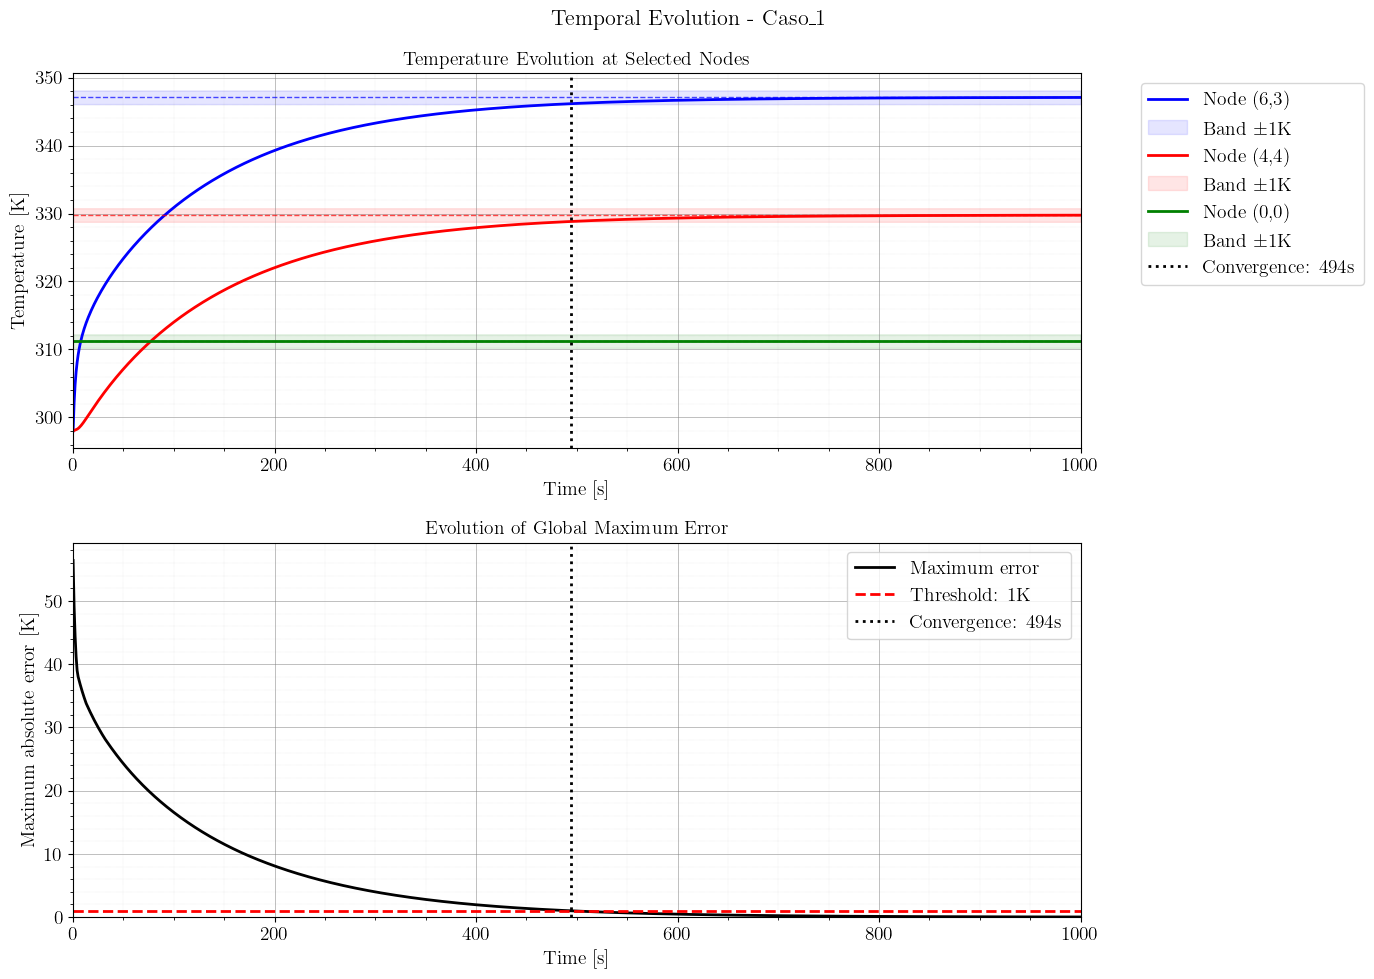


📊 Resumen para Caso_1:
   🔥 Potencias: [0.691124 0.558548 0.936811 1.220297]
   🌡️  T_env: 312.64K
   ✅ Convergencia alcanzada en 494s
   📈 Error final: 0.027K

🎯 Temperaturas finales vs estacionarias:
   Nodo_1_6_3 ((6, 3)): 347.09K vs 347.12K (Δ=0.025K)
   Nodo_2_4_4 ((4, 4)): 329.76K vs 329.79K (Δ=0.025K)
   Nodo_3_0_0 ((0, 0)): 311.22K vs 311.22K (Δ=0.000K)


In [20]:
# =============== VISUALIZACIÓN DE CASOS INDIVIDUALES ===============

# Visualizar cada caso por separado
for nombre_caso in evoluciones_detalladas.keys():
    print(f"\n📊 Visualizando {nombre_caso}...")
    visualizar_evolucion_temporal(evoluciones_detalladas, caso_a_mostrar=nombre_caso)

🔄 Comparando evolución entre casos...
💾 Figura guardada: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\figures\convergence_study\temporal_evolution_comparison.pdf


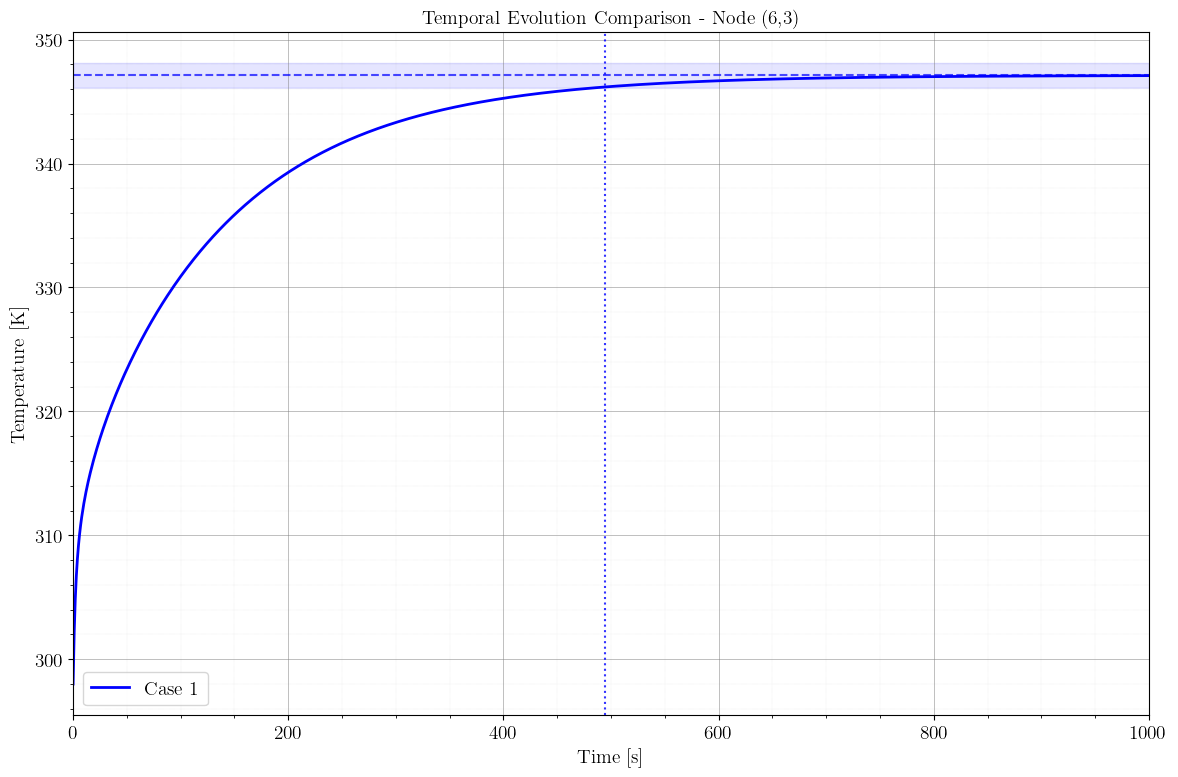

In [21]:
# Celda de visualización: Comparación entre casos
# =============== COMPARACIÓN ENTRE CASOS ===============

print("🔄 Comparando evolución entre casos...")
comparar_casos_evolucion(evoluciones_detalladas)